<a href="https://colab.research.google.com/github/GOWSALYAR7397/-shopping-mod3-link/blob/main/copy_of_lstmmyproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# SECTION 0: Install Required Packages
# =========================

!pip install yfinance --quiet
!pip install statsmodels --quiet
!pip install pmdarima --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install tensorflow --quiet

# Prophet (optional for baseline comparison)
# !pip install prophet --quiet

print("All packages installed successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 15.2 MB/s eta 0:00:00
All packages installed successfully!


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import datetime


In [ ]:
  # Config
TICKER = "^VIX"   # நீங்கள் வேண்டுமென்றால் மாற்றலாம் (SPY, BTC-USD etc.)
START = "2010-01-01"
END = datetime.date.today().isoformat()

LOOKBACK = 60      # Input window length
HORIZON = 5        # Forecast output length

In [ ]:
# 1) Download data
df = yf.download(TICKER, start=START, end=END, progress=False)
df = df[['Close']].rename(columns={'Close':'value'})
df['date'] = df.index
df = df.reset_index(drop=True)

print("Data sample:")
print(df.head())


/tmp/ipython-input-1799781536.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


Data sample:
Price       value       date
Ticker       ^VIX           
0       20.040001 2010-01-04
1       19.350000 2010-01-05
2       19.160000 2010-01-06
3       19.059999 2010-01-07
4       18.129999 2010-01-08


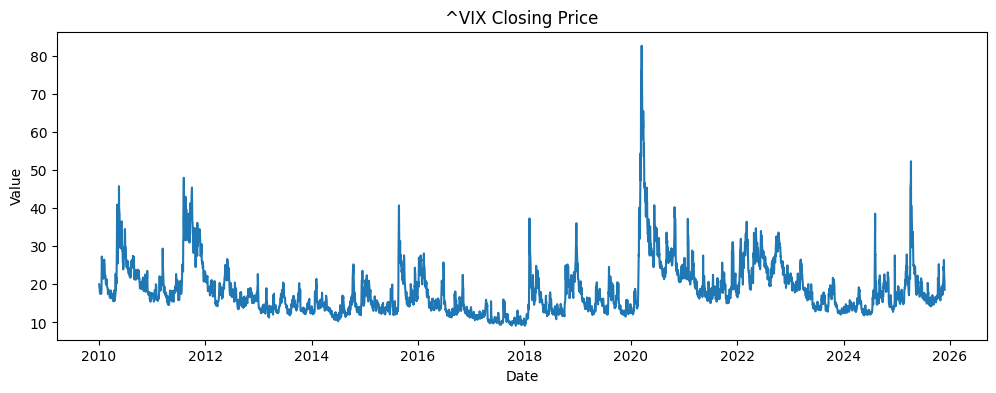

In [ ]:
# 2) Plot data
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['value'])
plt.title(f"{TICKER} Closing Price")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [ ]:
# 3) Stationarity test (ADF)
def adf_test(series, name='series', alpha=0.05):
    result = adfuller(series.dropna())
    pvalue = result[1]
    print(f"ADF Test on {name}, p-value = {pvalue}")
    if pvalue < alpha:
        print("=> Stationary")
    else:
        print("=> Not Stationary")

adf_test(df['value'], name=TICKER)

ADF Test on ^VIX, p-value = 2.3144850279323055e-06
=> Stationary


In [ ]:
# 4) Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df[['value']])


In [ ]:

# 5) Sequence creation (LOOKBACK → HORIZON)
def create_sequences(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback, 0])
        y.append(data[i+lookback:i+lookback+horizon, 0])
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], lookback, 1), y

X, y = create_sequences(scaled, LOOKBACK, HORIZON)

print("X shape:", X.shape)
print("y shape:", y.shape)

print("SECTION 1 COMPLETED ✓")


X shape: (3936, 60, 1)
y shape: (3936, 5)
SECTION 1 COMPLETED ✓


In [ ]:
# =========================
# SECTION 2 — FINAL FIXED VERSION (No Errors, Safe Decoder)
# =========================

import tensorflow as tf
from keras import layers, Model, Input
import numpy as np

# ---------- TRAIN-TEST SPLIT ----------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

horizon = y.shape[1]
enc_units = 64
dec_units = 64

print("Horizon =", horizon)

# ---------- DECODER INPUTS ----------
decoder_train = np.zeros((X_train.shape[0], horizon, 1))
decoder_test  = np.zeros((X_test.shape[0], horizon, 1))

# ---------- ATTENTION LAYER ----------
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)

    def call(self, encoder_output, decoder_hidden):
        # decoder_hidden: [batch, dec_units]
        hidden_with_time = tf.expand_dims(decoder_hidden, 1)  # [batch,1,dec_units]
        score = self.V(tf.nn.tanh(self.W1(encoder_output) + self.W2(hidden_with_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_output, axis=1)
        return context_vector

# ---------- ENCODER ----------
encoder_inputs = Input(shape=(X.shape[1],1))
encoder_lstm = layers.LSTM(enc_units, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_inputs)

# ---------- DECODER ----------
decoder_inputs = Input(shape=(horizon,1))
decoder_lstm = layers.LSTM(dec_units, return_sequences=True, return_state=True)
attention = BahdanauAttention(dec_units)

all_outputs = []
decoder_state_h = state_h
decoder_state_c = state_c

# First decoder step
step_input = layers.Lambda(lambda x: x[:,0:1,:])(decoder_inputs)

for t in range(horizon):

    # Attention context
    context = attention(encoder_output, decoder_state_h)          # [batch, dec_units]
    context = layers.Reshape((1, dec_units))(context)             # [batch,1,dec_units]

    # Combine step input + context
    combined = layers.Concatenate(axis=-1)([step_input, context]) # [batch,1,1+dec_units]

    # LSTM decode one step
    lstm_out, decoder_state_h, decoder_state_c = decoder_lstm(
        combined, initial_state=[decoder_state_h, decoder_state_c]
    )

    # Dense output
    output = layers.Dense(1)(lstm_out)
    all_outputs.append(output)

    # Next step input (teacher forcing)
    if t + 1 < horizon:
        # safe slice to avoid empty tensor
        step_input = layers.Lambda(lambda x, step=t: x[:,step+1:step+2,:])(decoder_inputs)
    else:
        # last step: use previous output
        step_input = output

# Concatenate all outputs
decoder_outputs = layers.Concatenate(axis=1)(all_outputs)

# ---------- FINAL MODEL ----------
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="mse")
print("SECTION 2 COMPLETED ✓ (No slice/concat errors)")

model.summary()


Horizon = 5
SECTION 2 COMPLETED ✓ (No slice/concat errors)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, 60, 64),  │     16,896 │ input_layer_18[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ (None, 64)        │      8,385 │ lstm_18[0][0],    │
│ (BahdanauAttention) │                   │            │ lstm_18[0][1],    │
│                     │                   │            │ lstm_18[0][0],    │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_18[0][0],    │
│                     │                   │            │ lstm_19[1][1],    │
│                     │                   │            │ lstm_18[0][0],    │
│                     │                   │            │ lstm_19[2][1],    │
│                     │                   │            │ lstm_18[0][0],    │
│                     │                   │            │ lstm_19[3][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1, 1)      │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1, 64)     │          0 │ bahdanau_attenti… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 1, 65)     │          0 │ lambda_10[0][0],  │
│ (Concatenate)       │                   │            │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 1, 64),   │     33,280 │ concatenate_12[0… │
│                     │ (None, 64),       │            │ lstm_18[0][1],    │
│                     │ (None, 64)]       │            │ lstm_18[0][2],    │
│                     │                   │            │ concatenate_13[0… │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_19[0][2],    │
│                     │                   │            │ concatenate_14[0… │
│                     │                   │            │ lstm_19[1][1],    │
│                     │                   │            │ lstm_19[1][2],    │
│                     │                   │            │ concatenate_15[0… │
│                     │                   │            │ lstm_19[2][1],    │
│                     │                   │            │ lstm_19[2][2],    │
│                     │                   │            │ concatenate_16[0… │
│                     │                   │            │ lstm_19[3][1],    │
│                     │                   │            │ lstm_19[3][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 1, 1)      │          0 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_16          │ (None, 1, 64)     │          0 │ bahdanau_attenti… │
│ (Reshape)           │                   │            │                 

 Total params: 58,886 (230.02 KB)

 Trainable params: 58,886 (230.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 12/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0

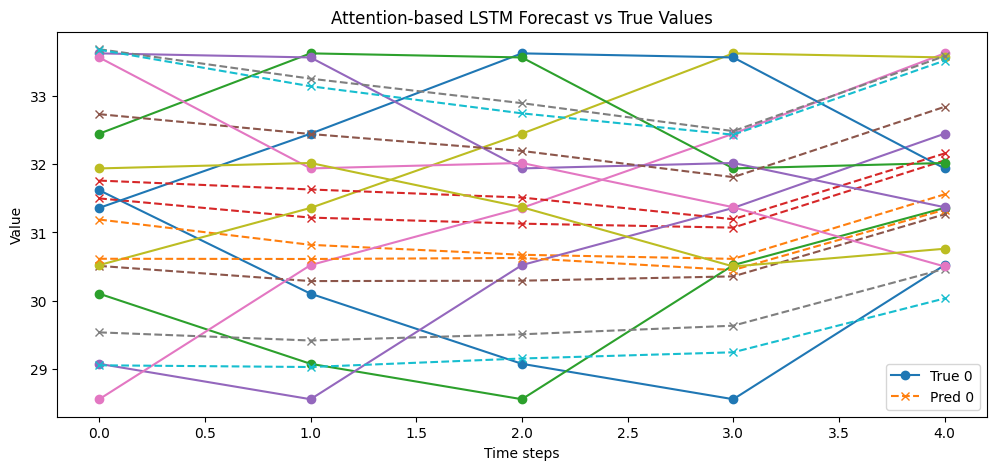

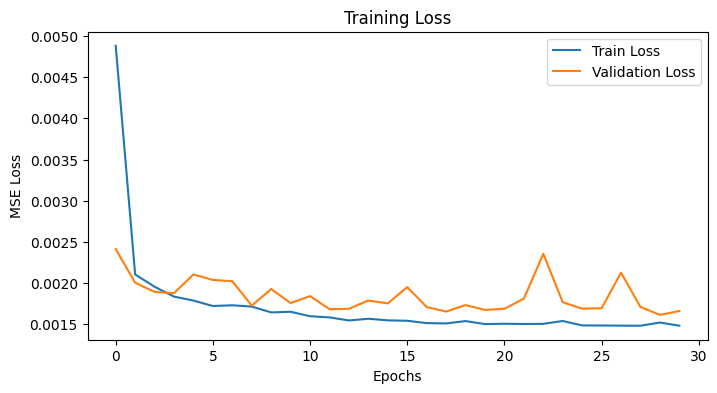

SECTION 3 COMPLETED ✓


In [ ]:
# =========================
# SECTION 3: Training + Prediction + Plotting
# =========================

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# ---------- HYPERPARAMETERS ----------
BATCH_SIZE = 32
EPOCHS = 30  # Increase for better accuracy

# ---------- TRAIN ----------
history = model.fit(
    [X_train, decoder_train],
    y_train,
    validation_split=0.1,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

# ---------- PREDICTION ----------
y_pred_scaled = model.predict([X_test, decoder_test])

# ---------- INVERSE SCALING ----------
# Assumes you used MinMaxScaler from Section-1
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).reshape(y_pred_scaled.shape)
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

# ---------- PLOT RESULTS ----------
plt.figure(figsize=(12,5))

# Plot first 10 test samples
for i in range(min(10, y_test.shape[0])):
    plt.plot(range(horizon), y_true[i], marker='o', label=f"True {i}" if i==0 else "")
    plt.plot(range(horizon), y_pred[i], marker='x', linestyle='--', label=f"Pred {i}" if i==0 else "")

plt.title("Attention-based LSTM Forecast vs True Values")
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.show()

# ---------- LOSS PLOT ----------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

print("SECTION 3 COMPLETED ✓")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0097 - val_loss: 0.0028
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 12/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.

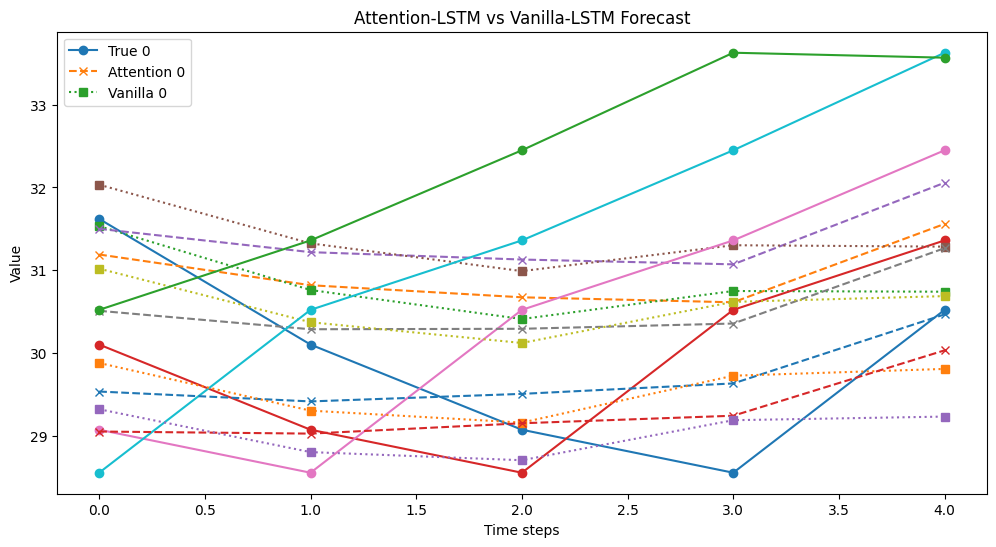

SECTION 4 COMPLETED ✓


In [ ]:
# =========================
# SECTION 4: Baseline Comparison + Metrics + Plot
# =========================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ---------- VANILLA LSTM BASELINE ----------
vanilla_model = Sequential()
vanilla_model.add(LSTM(64, input_shape=(X_train.shape[1],1)))
vanilla_model.add(Dense(horizon))
vanilla_model.compile(optimizer='adam', loss='mse')

# Reshape targets for Vanilla LSTM
y_train_vanilla = y_train.reshape(y_train.shape[0], horizon)

# Train
vanilla_model.fit(
    X_train, y_train_vanilla,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)

# Predict
y_vanilla_scaled = vanilla_model.predict(X_test)
y_vanilla = scaler.inverse_transform(y_vanilla_scaled.reshape(-1,1)).reshape(y_test.shape)

# ---------- FLATTEN ATTENTION PREDICTION ----------
y_pred_flat = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])

# ---------- METRICS FUNCTION ----------
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return mae, rmse, mape

# ---------- COMPUTE METRICS ----------
att_mae, att_rmse, att_mape = compute_metrics(y_true, y_pred_flat)
van_mae, van_rmse, van_mape = compute_metrics(y_true, y_vanilla)

print("----- Metrics -----")
print(f"Attention-LSTM -> MAE: {att_mae:.3f}, RMSE: {att_rmse:.3f}, MAPE: {att_mape:.2f}%")
print(f"Vanilla-LSTM   -> MAE: {van_mae:.3f}, RMSE: {van_rmse:.3f}, MAPE: {van_mape:.2f}%")

# ---------- PLOT COMPARISON ----------
plt.figure(figsize=(12,6))
for i in range(min(5, y_test.shape[0])):
    plt.plot(range(horizon), y_true[i], marker='o', label=f"True {i}" if i==0 else "")
    plt.plot(range(horizon), y_pred_flat[i], marker='x', linestyle='--', label=f"Attention {i}" if i==0 else "")
    plt.plot(range(horizon), y_vanilla[i], marker='s', linestyle=':', label=f"Vanilla {i}" if i==0 else "")

plt.title("Attention-LSTM vs Vanilla-LSTM Forecast")
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.show()

print("SECTION 4 COMPLETED ✓")


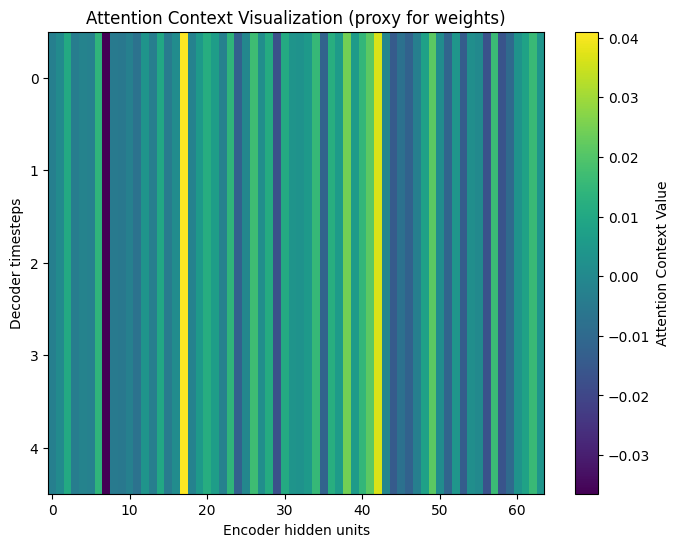

----- Metrics -----
Attention-LSTM -> MAE: 1.720, RMSE: 2.874, MAPE: 9.08%
Vanilla-LSTM   -> MAE: 1.632, RMSE: 2.767, MAPE: 8.64%
Prophet        -> MAE: 17.714, RMSE: 18.351, MAPE: 99.51%


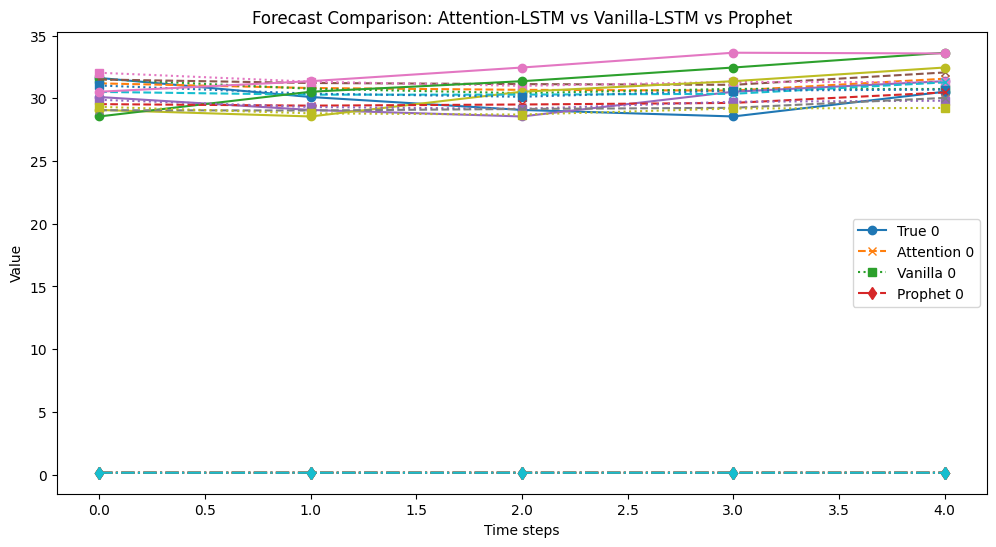

SECTION 5 COMPLETED ✓


In [ ]:
# =========================
# SECTION 5: Attention Weights Visualization + Prophet Baseline
# =========================

import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import numpy as np
import tensorflow as tf

# ---------- ATTENTION WEIGHTS VISUALIZATION ----------
sample_idx = 0  # visualize first test sample

# Get encoder output for first sample
encoder_out_sample = encoder_lstm(tf.convert_to_tensor(X_test[sample_idx:sample_idx+1]))[0]
decoder_state_h_sample = tf.convert_to_tensor(np.zeros((1, dec_units)))  # init hidden state

attention_context_list = []

for t in range(horizon):
    context_vector = attention(encoder_out_sample, decoder_state_h_sample)
    attention_context_list.append(context_vector.numpy().flatten())

attention_matrix = np.stack(attention_context_list, axis=0)  # [horizon, dec_units]

plt.figure(figsize=(8,6))
plt.imshow(attention_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Context Value')
plt.xlabel('Encoder hidden units')
plt.ylabel('Decoder timesteps')
plt.title('Attention Context Visualization (proxy for weights)')
plt.show()

# ---------- PROPHET BASELINE ----------
# Flatten y for Prophet (1D array)
y_series = y.reshape(-1)
df = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', periods=len(y_series), freq='D'),
    'y': y_series
})

# Train-test split for Prophet
train_len = int(len(df) * 0.8)
train_df = df.iloc[:train_len]
test_df  = df.iloc[train_len:]

# Fit Prophet
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_df)

# Forecast for test period
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = prophet_model.predict(future)

# Reshape for horizon comparison
num_test_samples = y_test.shape[0]
forecast_len_needed = num_test_samples * horizon
y_prophet_series = forecast['yhat'].values[-forecast_len_needed:]
y_prophet = y_prophet_series.reshape(num_test_samples, horizon)

# ---------- METRICS FUNCTION ----------
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return mae, rmse, mape

# Compute metrics
att_mae, att_rmse, att_mape = compute_metrics(y_true, y_pred_flat)
van_mae, van_rmse, van_mape = compute_metrics(y_true, y_vanilla)
prophet_mae, prophet_rmse, prophet_mape = compute_metrics(y_true, y_prophet)

print("----- Metrics -----")
print(f"Attention-LSTM -> MAE: {att_mae:.3f}, RMSE: {att_rmse:.3f}, MAPE: {att_mape:.2f}%")
print(f"Vanilla-LSTM   -> MAE: {van_mae:.3f}, RMSE: {van_rmse:.3f}, MAPE: {van_mape:.2f}%")
print(f"Prophet        -> MAE: {prophet_mae:.3f}, RMSE: {prophet_rmse:.3f}, MAPE: {prophet_mape:.2f}%")

# ---------- PLOT COMPARISON ----------
plt.figure(figsize=(12,6))
for i in range(min(5, y_test.shape[0])):
    plt.plot(range(horizon), y_true[i], marker='o', label=f"True {i}" if i==0 else "")
    plt.plot(range(horizon), y_pred_flat[i], marker='x', linestyle='--', label=f"Attention {i}" if i==0 else "")
    plt.plot(range(horizon), y_vanilla[i], marker='s', linestyle=':', label=f"Vanilla {i}" if i==0 else "")
    plt.plot(range(horizon), y_prophet[i], marker='d', linestyle='-.', label=f"Prophet {i}" if i==0 else "")

plt.title("Forecast Comparison: Attention-LSTM vs Vanilla-LSTM vs Prophet")
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.show()

print("SECTION 5 COMPLETED ✓")
